 - Pilot: 
 - Copilot: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

/tmp/ipykernel_1099197/2222651814.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## Bicicletas

Intentamos entender qué variables pueden afectar a la demanda de un sistema de alquiler de bicicletas. 

La variable objetivo es \texttt{cnt}, el número total de alquileres, y las posibles variables explicativas son

- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- temp : Normalized temperature in Celsius.
- atemp: Normalized feeling temperature in Celsius.
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- cnt: count of total rental bikes including both casual and registered 

In [2]:
bikes = pd.read_csv('bikesharing.csv')
bikes

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1  01-01-2018       1   0     1        0        1           1   
1          2  02-01-2018       1   0     1        0        2           1   
2          3  03-01-2018       1   0     1        0        3           1   
3          4  04-01-2018       1   0     1        0        4           1   
4          5  05-01-2018       1   0     1        0        5           1   
..       ...         ...     ...  ..   ...      ...      ...         ...   
725      726  27-12-2019       1   1    12        0        5           1   
726      727  28-12-2019       1   1    12        0        6           0   
727      728  29-12-2019       1   1    12        0        0           0   
728      729  30-12-2019       1   1    12        0        1           1   
729      730  31-12-2019       1   1    12        0        2           1   

     weathersit       temp     atemp      hum  windspeed  casual  registered  \
0             2  14.110847  18.18125  80.5833  10.749882     331         654   
1             2  14.902598  17.68695  69.6087  16.652113     131         670   
2             1   8.050924   9.47025  43.7273  16.636703     120        1229   
3             1   8.200000  10.60610  59.0435  10.739832     108        1454   
4             1   9.305237  11.46350  43.6957  12.522300      82        1518   
..          ...        ...       ...      ...        ...     ...         ...   
725           2  10.420847  11.33210  65.2917  23.458911     247        1867   
726           2  10.386653  12.75230  59.0000  10.416557     644        2451   
727           2  10.386653  12.12000  75.2917   8.333661     159        1182   
728           1  10.489153  11.58500  48.3333  23.500518     364        1432   
729           2   8.849153  11.17435  57.7500  10.374682     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
725  2114  
726  3095  
727  1341  
728  1796  
729  2729  

[730 rows x 16 columns]

Como las entradas están desordenadas, el siguiente código introduce el número de días desde la puesta en marcha del servicio. Observamos que el segundo la adopción fue mayor...

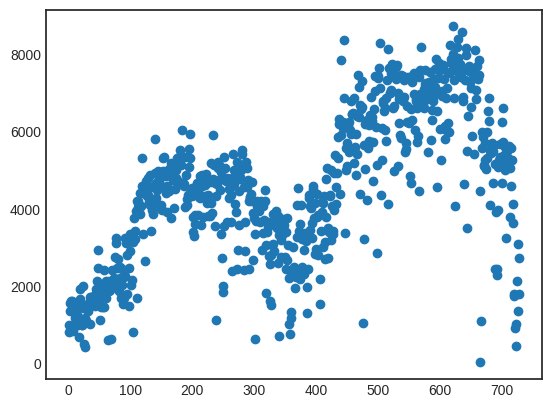

In [3]:
# No le prestes mucha atención: no vamos a usar este código...
bikes['dt'] = pd.to_datetime(bikes.dteday, dayfirst=True)
start = bikes.dt.min()
bikes['days'] = (bikes.dt - start).transform(lambda s:s.days)
plt.scatter(bikes.days, bikes.cnt)

Por este motivo, vamos a estudiar únicamente el rendimiento del servicio durante el último año

## Ejercicio 1

 - Construye un DataFrame que contenga sólo los registros del último año de funcionamiento.
 - Realiza un análisis exploratorio. 
     + Haz un scatter plot de `temp` contra `atemp` y comenta el resultado.
     + Indica qué variables deberían ser categóricas y cuáles de ellas parecen numéricas pero deberían ser tratadas como variables categóricas.
 - Elige un modelo de regresión lineal múltiple comparando al menos 3 modelos razonables. _Justifica las decisiones tomadas_.

In [4]:
# Construye un DataFrame que contenga sólo los registros del último año de funcionamiento.
bikes_y2 = bikes[bikes.yr==1]

> - Realiza un análisis exploratorio

In [6]:
bikes_y2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 365 to 729
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     365 non-null    int64         
 1   dteday      365 non-null    object        
 2   season      365 non-null    int64         
 3   yr          365 non-null    int64         
 4   mnth        365 non-null    int64         
 5   holiday     365 non-null    int64         
 6   weekday     365 non-null    int64         
 7   workingday  365 non-null    int64         
 8   weathersit  365 non-null    int64         
 9   temp        365 non-null    float64       
 10  atemp       365 non-null    float64       
 11  hum         365 non-null    float64       
 12  windspeed   365 non-null    float64       
 13  casual      365 non-null    int64         
 14  registered  365 non-null    int64         
 15  cnt         365 non-null    int64         
 16  dt          365 non-null

In [7]:
bikes_y2.describe(include='all')

/tmp/ipykernel_1099197/3898350448.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bikes_y2.describe(include='all')


instant      dteday      season     yr        mnth     holiday  \
count   365.000000         365  365.000000  365.0  365.000000  365.000000   
unique         NaN         365         NaN    NaN         NaN         NaN   
top            NaN  01-01-2019         NaN    NaN         NaN         NaN   
freq           NaN           1         NaN    NaN         NaN         NaN   
first          NaN         NaN         NaN    NaN         NaN         NaN   
last           NaN         NaN         NaN    NaN         NaN         NaN   
mean    548.000000         NaN    2.498630    1.0    6.526027    0.030137   
std     105.510663         NaN    1.110946    0.0    3.452584    0.171199   
min     366.000000         NaN    1.000000    1.0    1.000000    0.000000   
25%     457.000000         NaN    2.000000    1.0    4.000000    0.000000   
50%     548.000000         NaN    3.000000    1.0    7.000000    0.000000   
75%     639.000000         NaN    3.000000    1.0   10.000000    0.000000   
max     730.000000         NaN    4.000000    1.0   12.000000    1.000000   

           weekday  workingday  weathersit        temp       atemp  \
count   365.000000  365.000000  365.000000  365.000000  365.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
first          NaN         NaN         NaN         NaN         NaN   
last           NaN         NaN         NaN         NaN         NaN   
mean      2.997260    0.684932    1.367123   20.685256   24.110876   
std       2.000685    0.465181    0.515703    7.222334    7.840748   
min       0.000000    0.000000    1.000000    4.407500    5.082900   
25%       1.000000    0.000000    1.000000   14.281653   17.581450   
50%       3.000000    1.000000    1.000000   21.080847   25.125650   
75%       5.000000    1.000000    2.000000   26.820847   30.398100   
max       6.000000    1.000000    3.000000   35.328347   40.245650   

               hum   windspeed       casual   registered          cnt  \
count   365.000000  365.000000   365.000000   365.000000   365.000000   
unique         NaN         NaN          NaN          NaN          NaN   
top            NaN         NaN          NaN          NaN          NaN   
freq           NaN         NaN          NaN          NaN          NaN   
first          NaN         NaN          NaN          NaN          NaN   
last           NaN         NaN          NaN          NaN          NaN   
mean     61.163873   12.703263  1021.095890  4589.156164  5610.252055   
std      13.400919    5.246048   758.382362  1418.627732  1780.183449   
min      25.416700    3.125550     2.000000    20.000000    22.000000   
25%      50.791700    8.959307   432.000000  3735.000000  4375.000000   
50%      61.125000   11.707982   905.000000  4790.000000  5936.000000   
75%      70.958300   15.500718  1263.000000  5665.000000  7013.000000   
max      92.500000   29.584721  3410.000000  6946.000000  8714.000000   

                         dt        days  
count                   365  365.000000  
unique                  365         NaN  
top     2019-01-01 00:00:00         NaN  
freq                      1         NaN  
first   2019-01-01 00:00:00         NaN  
last    2019-12-31 00:00:00         NaN  
mean                    NaN  547.000000  
std                     NaN  105.510663  
min                     NaN  365.000000  
25%                     NaN  456.000000  
50%                     NaN  547.000000  
75%                     NaN  638.000000  
max                     NaN  729.000000

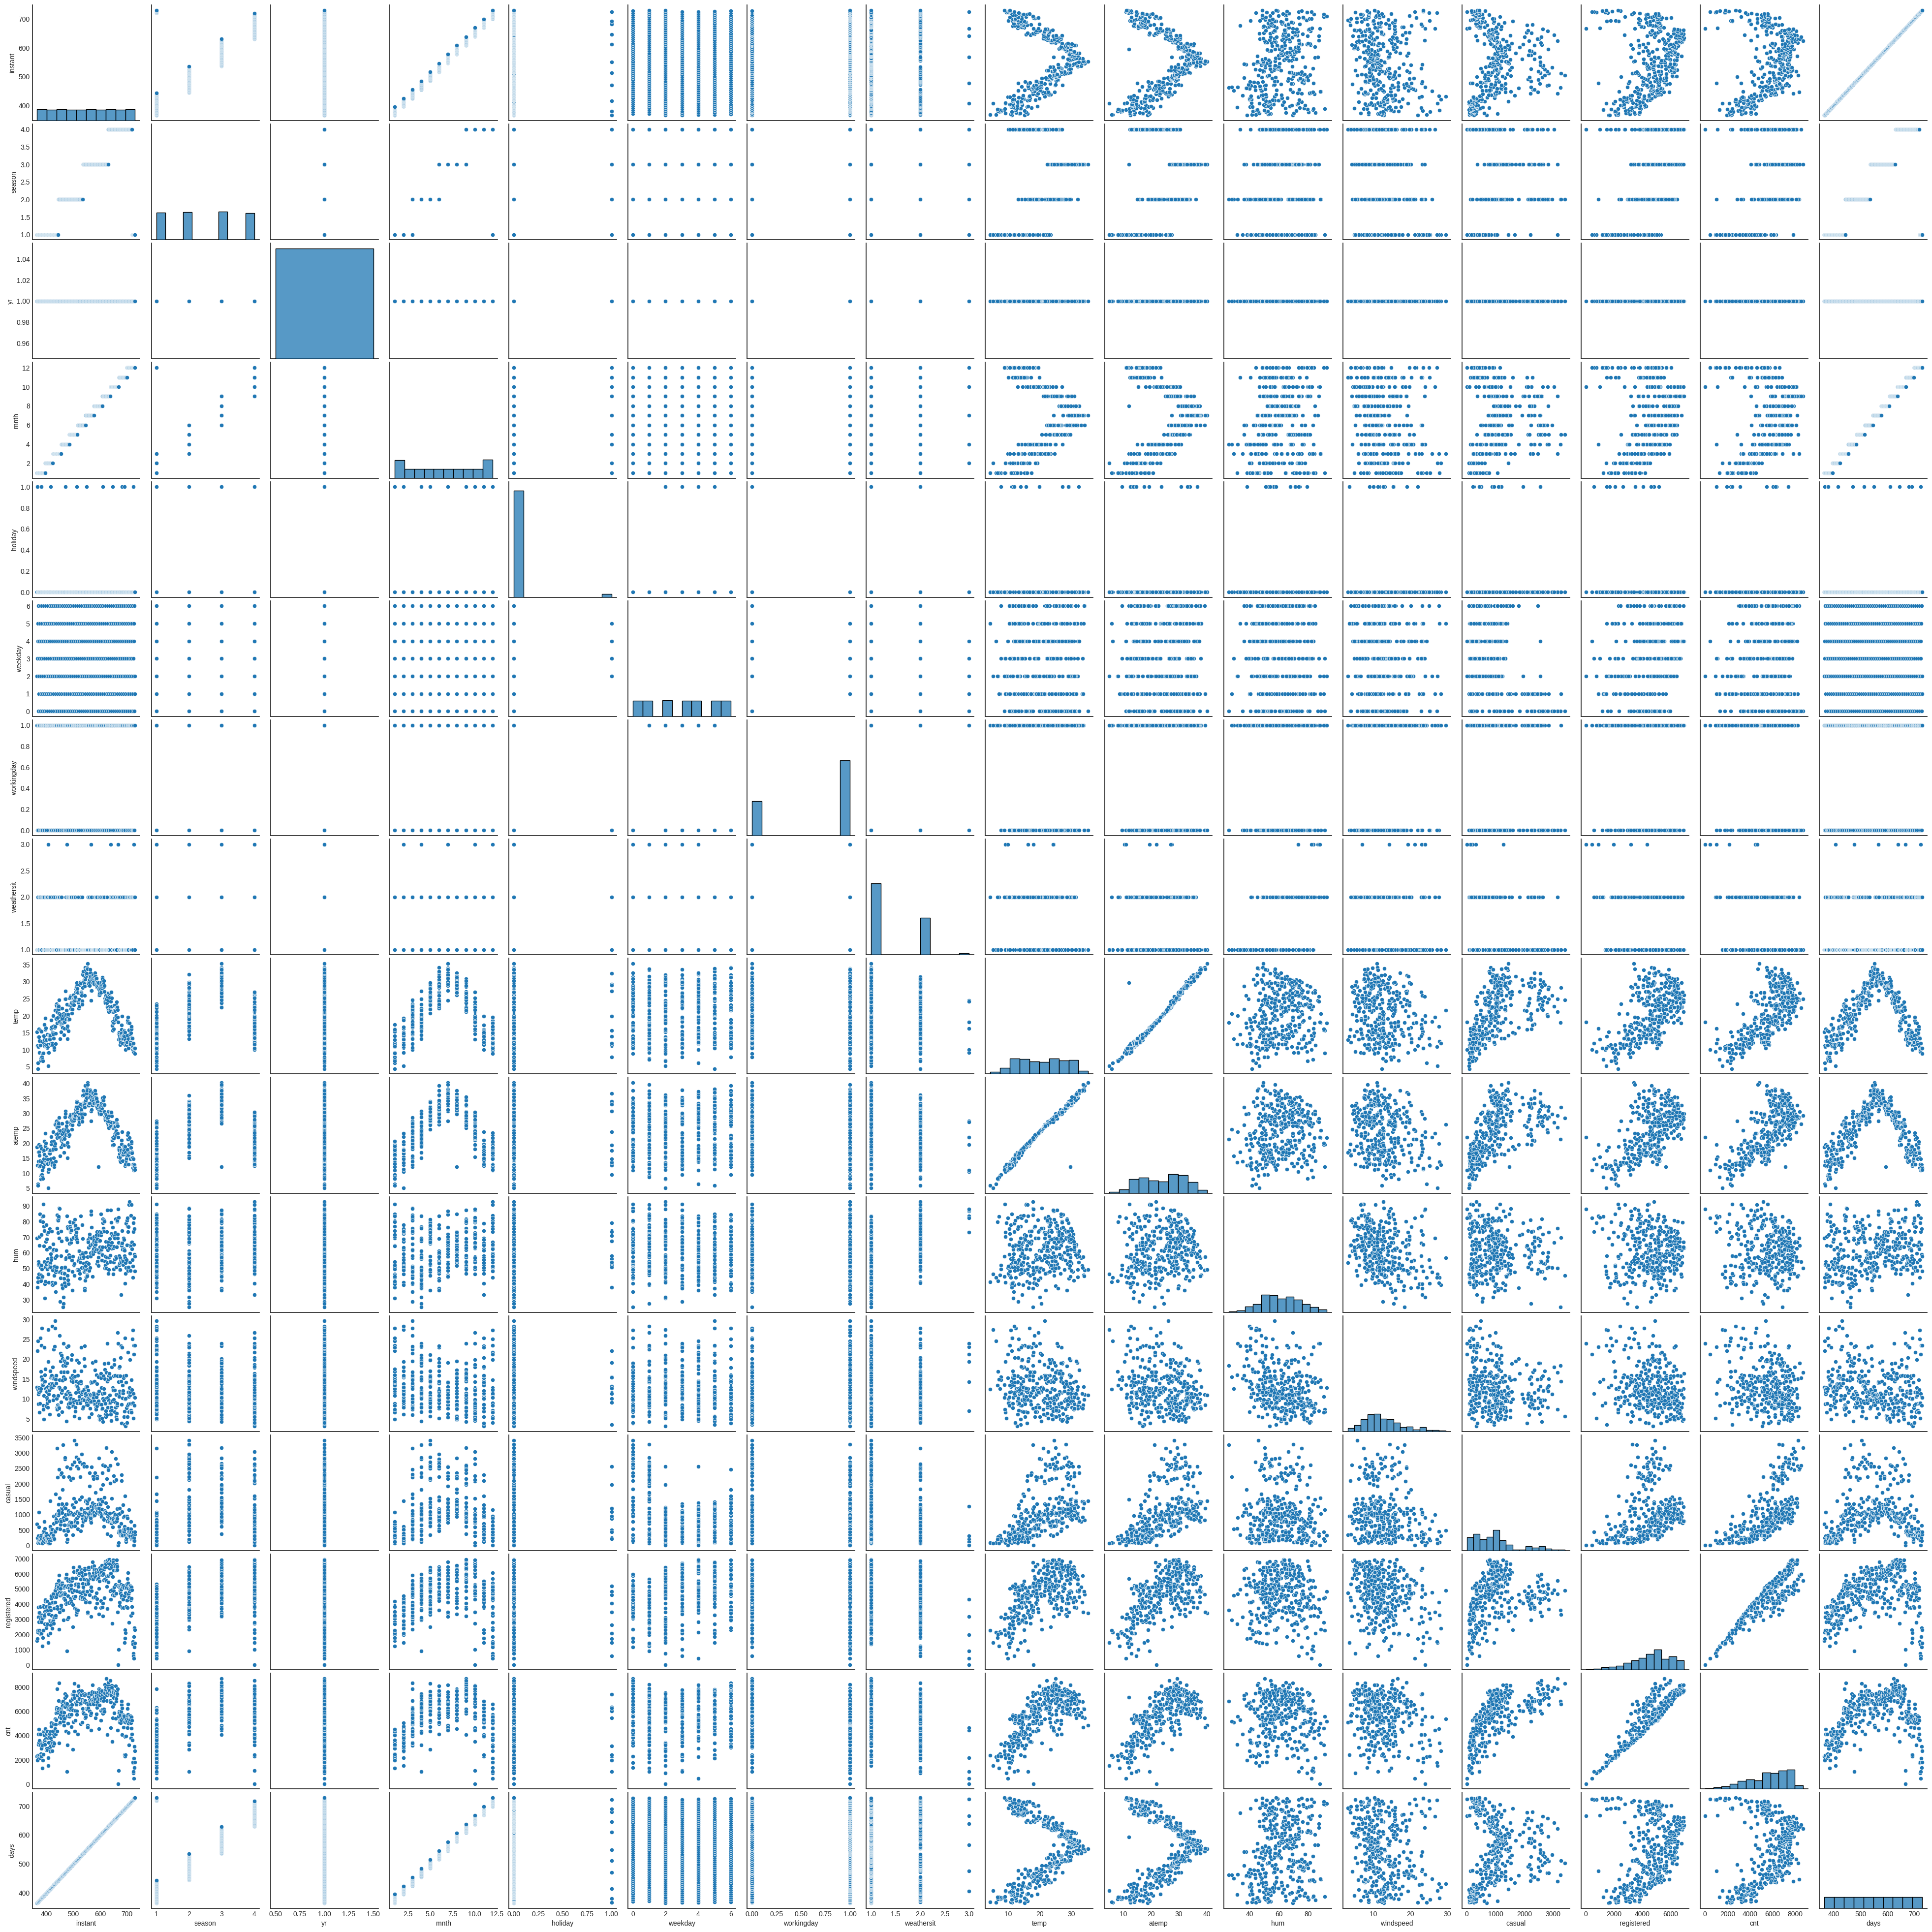

In [8]:
sns.pairplot(bikes_y2)

Observamos:

 - temp 	atemp 	hum 	windspeed 	son variables numéricas y continuas
 - cnt, casual y registered son numéricas, enteras
 - 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit' son discretas, y en realidad codifican conceptos que no son naturalmente numéricos, aunque los valores estén codificados como valores numéricos. Son todas categóricas.
     + De todas ellas, las que toman dos valores 0 y 1 ('holiday' y 'workingday') se pueden usar en una regresión lineal, porque ya están en la codificación one-hot, pero 'season', 'mnth', 'weekday' y 'weathersit' no siguen la codificación one-hot.

<AxesSubplot: xlabel='temp', ylabel='atemp'>

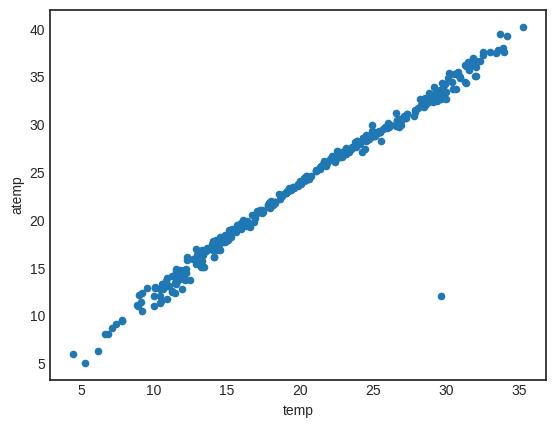

In [9]:
# Haz un scatter plot de `temp` contra `atemp` y comenta el resultado.
bikes_y2.plot.scatter('temp', 'atemp')

La tendencia es clara: hay una relación aproximadamente lineal entre 'temp' y 'atemp'. 

Pero observamos un __valor atípico__, que parece fuera de la tendencia general.

Lo identificamos filtrando los puntos cuya `temp` es mayor que 25 y cuya `atemp` es menor que 20.

In [10]:
bikes_y2[(bikes_y2.temp>25) & (bikes_y2.atemp<20)]

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
593      594  17-08-2019       3   1     8        0        6           0   

     weathersit       temp  atemp      hum  windspeed  casual  registered  \
593           1  29.656653  12.12  57.0833  15.500718    1483        5665   

      cnt         dt  days  
593  7148 2019-08-17   593

Comprobamos los rangos de las variables que afectan al clima, por si pudiera ser que ese día (17-08-2019) hubiera algún evento extraordinario...

In [11]:
bikes_y2[['hum','windspeed']].describe()

hum   windspeed
count  365.000000  365.000000
mean    61.163873   12.703263
std     13.400919    5.246048
min     25.416700    3.125550
25%     50.791700    8.959307
50%     61.125000   11.707982
75%     70.958300   15.500718
max     92.500000   29.584721

Vemos que el 17-08-2019, los valores de `hum` y `windspeed` no eran anómalos (y `weathersit` es 1), así que concluimos que el valor anómalo se debió a un error de transcripción o similar. Idea de Ignacio e Ignacio: hacemos un histograma de los valores de `temp` y `atemp` en agosto, y concluimos que probablemente el valor anómalo es el de `atemp`:

Text(0.5, 0, 'temp')

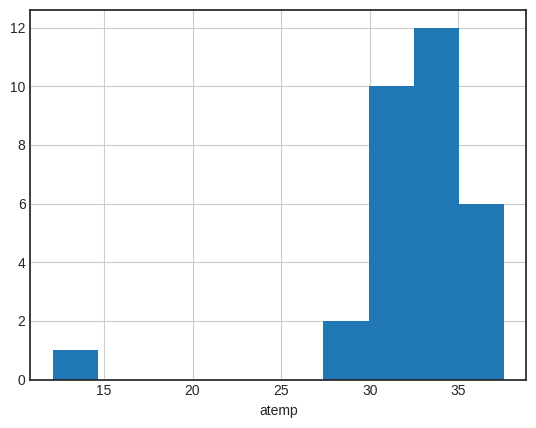

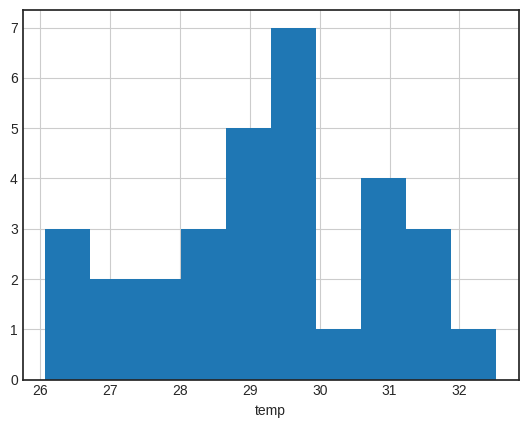

In [12]:
bikes_y2_m8 = bikes_y2[bikes_y2.mnth==8]
bikes_y2_m8.atemp.hist()
plt.xlabel('atemp')
plt.figure()
bikes_y2_m8.temp.hist()
plt.xlabel('temp')

> - Elige un modelo de regresión lineal múltiple comparando al menos 3 modelos razonables. _Justifica las decisiones tomadas_.

Comenzamos con un modelo con todas las variables razonables. No usamos `casual` ni `registered`, ya que `cnt` es la suma de ambas, pero son variables que conocemos a la vez que `cnt`, luego no tiene sentido que aparezcan en una regresión. El objetivo es predecir el número de alquileres usando el pronóstico del tiempo y el calendario laboral.

_Nos aseguramos de que las variables categóricas se usen adecuadamente, usando la codificación one-hot_

In [13]:
regr=smf.ols("cnt~C(season)+C(mnth) + holiday + C(weekday) + workingday + C(weathersit) + temp + atemp + hum + windspeed", bikes_y2).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     45.65
Date:                Sun, 28 May 2023   Prob (F-statistic):           8.40e-96
Time:                        14:04:58   Log-Likelihood:                -2968.5
No. Observations:                 365   AIC:                             5993.
Df Residuals:                     337   BIC:                             6102.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3854.7135    404.068      9.540      0.000    3059.900    4649.527
C(season)[T.2]      1224.5879    286.311      4.277      0.000     661.406    1787.770
C(season)[T.3]       591.2863    348.970      1.694      0.091     -95.148    1277.720
C(season)[T.4]      1820.7689    292.845      6.218      0.000    1244.734    2396.804
C(mnth)[T.2]         261.1401    227.340      1.149      0.252    -186.044     708.325
C(mnth)[T.3]         842.4482    268.670      3.136      0.002     313.967    1370.929
C(mnth)[T.4]         354.6776    391.220      0.907      0.365    -414.863    1124.218
C(mnth)[T.5]         297.3939    419.770      0.708      0.479    -528.306    1123.093
C(mnth)[T.6]         318.8746    430.200      0.741      0.459    -527.341    1165.090
C(mnth)[T.7]         292.6901    472.380      0.620      0.536    -636.495    1221.875
C(mnth)[T.8]         872.5910    455.631      1.915      0.056     -23.649    1768.831
C(mnth)[T.9]        1401.7939    397.605      3.526      0.000     619.694    2183.894
C(mnth)[T.10]        553.9520    375.563      1.475      0.141    -184.791    1292.695
C(mnth)[T.11]       -348.7040    361.000     -0.966      0.335   -1058.801     361.393
C(mnth)[T.12]       -307.7303    287.182     -1.072      0.285    -872.626     257.165
C(weekday)[T.1]     -510.4878    123.005     -4.150      0.000    -752.442    -268.533
C(weekday)[T.2]     -329.0653    114.622     -2.871      0.004    -554.530    -103.601
C(weekday)[T.3]     -190.9981    116.006     -1.646      0.101    -419.186      37.190
C(weekday)[T.4]        6.0450    121.702      0.050      0.960    -233.346     245.436
C(weekday)[T.5]      -10.2424    121.529     -0.084      0.933    -249.294     228.809
C(weekday)[T.6]      -65.1308    169.502     -0.384      0.701    -398.547     268.285
C(weathersit)[T.2]  -571.6061    125.835     -4.542      0.000    -819.127    -324.085
C(weathersit)[T.3] -2449.1114    404.834     -6.050      0.000   -3245.431   -1652.792
holiday             -909.4535    245.692     -3.702      0.000   -1392.736    -426.171
workingday          -125.2951    104.631     -1.197      0.232    -331.107      80.516
temp                  91.7461     45.003      2.039      0.042       3.224     180.268
atemp                 28.2192     37.408      0.754      0.451     -45.364     101.802
hum                  -16.3309      5.035     -3.244      0.001     -26.234      -6.428
windspeed            -47.6401      9.746     -4.888      0.000     -66.810     -28.470
==============================================================================
Omnibus:                       67.920   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.816
Skew:                          -0.943   Prob(JB):             

Probamos a eliminar `atemp`, ya que tiene un p-valor del estadístico t muy alto, y la información es probablemente redundante con la de `temp`.

In [14]:
regr=smf.ols("cnt~C(season)+C(mnth) + holiday + C(weekday) + workingday + C(weathersit) + temp + hum + windspeed", bikes_y2).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     47.45
Date:                Sun, 28 May 2023   Prob (F-statistic):           1.59e-96
Time:                        14:04:58   Log-Likelihood:                -2968.8
No. Observations:                 365   AIC:                             5992.
Df Residuals:                     338   BIC:                             6097.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3900.8170    399.165      9.772      0.000    3115.657    4685.977
C(season)[T.2]      1231.0034    286.002      4.304      0.000     668.435    1793.572
C(season)[T.3]       587.2644    348.707      1.684      0.093     -98.644    1273.173
C(season)[T.4]      1833.9658    292.136      6.278      0.000    1259.332    2408.599
C(mnth)[T.2]         264.7287    227.145      1.165      0.245    -182.068     711.525
C(mnth)[T.3]         847.3204    268.421      3.157      0.002     319.334    1375.306
C(mnth)[T.4]         360.3252    390.899      0.922      0.357    -408.576    1129.226
C(mnth)[T.5]         285.9615    419.229      0.682      0.496    -538.665    1110.588
C(mnth)[T.6]         303.3395    429.433      0.706      0.480    -541.358    1148.037
C(mnth)[T.7]         276.7704    471.608      0.587      0.558    -650.885    1204.426
C(mnth)[T.8]         836.6239    452.841      1.848      0.066     -54.117    1727.365
C(mnth)[T.9]        1399.4133    397.339      3.522      0.000     617.845    2180.981
C(mnth)[T.10]        544.5717    375.118      1.452      0.148    -193.287    1282.431
C(mnth)[T.11]       -357.0401    360.601     -0.990      0.323   -1066.345     352.264
C(mnth)[T.12]       -315.0691    286.834     -1.098      0.273    -879.274     249.136
C(weekday)[T.1]     -509.1748    122.914     -4.143      0.000    -750.948    -267.401
C(weekday)[T.2]     -327.4930    114.530     -2.859      0.005    -552.774    -102.212
C(weekday)[T.3]     -192.9031    115.905     -1.664      0.097    -420.889      35.083
C(weekday)[T.4]        3.5665    121.580      0.029      0.977    -235.582     242.715
C(weekday)[T.5]      -10.9954    121.448     -0.091      0.928    -249.884     227.893
C(weekday)[T.6]      -76.0283    168.778     -0.450      0.653    -408.016     255.959
C(weathersit)[T.2]  -572.5779    125.748     -4.553      0.000    -819.926    -325.230
C(weathersit)[T.3] -2464.9835    404.029     -6.101      0.000   -3259.711   -1670.256
holiday             -913.1354    245.487     -3.720      0.000   -1396.010    -430.261
workingday          -123.8643    104.547     -1.185      0.237    -329.509      81.780
temp                 122.9367     17.756      6.924      0.000      88.010     157.863
hum                  -16.1221      5.024     -3.209      0.001     -26.004      -6.240
windspeed            -49.0637      9.555     -5.135      0.000     -67.859     -30.268
==============================================================================
Omnibus:                       66.869   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.230
Skew:                          -0.932   Prob(JB):                     3.94e-33
Kurtosis:                       5.517   Cond. No.                     

Según los criterios AIC y BIC es mejor quitar la variable, y adj-R2 no es concluyente. 
Quitamos por tanto la variable y probamos ahora a eliminar `weekday`, ya que algunas de las variables `one-hot` tienen un p-valor del estadístico t muy alto.

In [15]:
regr=smf.ols("cnt~C(season)+C(mnth) + holiday + workingday + C(weathersit) + temp + hum + windspeed", bikes_y2).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     56.77
Date:                Sun, 28 May 2023   Prob (F-statistic):           4.35e-98
Time:                        14:04:58   Log-Likelihood:                -2975.7
No. Observations:                 365   AIC:                             5995.
Df Residuals:                     343   BIC:                             6081.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3916.1696    393.679      9.948      0.000    3141.841    4690.498
C(season)[T.2]      1282.5576    288.918      4.439      0.000     714.284    1850.832
C(season)[T.3]       627.1096    352.512      1.779      0.076     -66.247    1320.466
C(season)[T.4]      1843.1945    295.426      6.239      0.000    1262.120    2424.269
C(mnth)[T.2]         244.5874    229.732      1.065      0.288    -207.274     696.449
C(mnth)[T.3]         784.2078    270.824      2.896      0.004     251.523    1316.893
C(mnth)[T.4]         223.2464    393.378      0.568      0.571    -550.490     996.983
C(mnth)[T.5]         156.7483    422.180      0.371      0.711    -673.639     987.136
C(mnth)[T.6]         129.2568    431.160      0.300      0.765    -718.793     977.307
C(mnth)[T.7]          79.6686    473.433      0.168      0.866    -851.530    1010.867
C(mnth)[T.8]         681.9018    455.900      1.496      0.136    -214.811    1578.614
C(mnth)[T.9]        1261.7239    400.019      3.154      0.002     474.924    2048.524
C(mnth)[T.10]        481.2064    379.084      1.269      0.205    -264.416    1226.828
C(mnth)[T.11]       -387.7961    364.633     -1.064      0.288   -1104.995     329.403
C(mnth)[T.12]       -338.8091    290.079     -1.168      0.244    -909.366     231.748
C(weathersit)[T.2]  -571.6500    126.748     -4.510      0.000    -820.951    -322.349
C(weathersit)[T.3] -2470.5879    408.377     -6.050      0.000   -3273.826   -1667.350
holiday            -1098.0487    279.756     -3.925      0.000   -1648.302    -547.795
workingday          -289.0754    102.319     -2.825      0.005    -490.327     -87.824
temp                 129.8857     17.810      7.293      0.000      94.855     164.917
hum                  -17.8432      5.054     -3.530      0.000     -27.785      -7.902
windspeed            -51.0874      9.599     -5.322      0.000     -69.968     -32.207
==============================================================================
Omnibus:                       67.844   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.507
Skew:                          -0.988   Prob(JB):                     2.28e-30
Kurtosis:                       5.253   Cond. No.                     1.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Según los criterios adj-R2 y AIC es mejor dejar la variable, y según BIC es mejor quitarla. 
La diferencia de AIC es 3, mientras que la diferencia de BIC es de 16.
La decisión no es sencilla, pero optamos por quitarla.
Probamos ahora a eliminar `month`, ya que algunas de las variables `one-hot` derivadas de `month` tienen un p-valor del estadístico t muy alto.

In [16]:
regr=smf.ols("cnt~C(season) + holiday + workingday + C(weathersit) + temp + hum + windspeed", bikes_y2).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     94.14
Date:                Sun, 28 May 2023   Prob (F-statistic):           2.31e-93
Time:                        14:04:58   Log-Likelihood:                -3012.5
No. Observations:                 365   AIC:                             6047.
Df Residuals:                     354   BIC:                             6090.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3604.1674    377.987      9.535      0.000    2860.785    4347.550
C(season)[T.2]      1086.6860    185.763      5.850      0.000     721.349    1452.023
C(season)[T.3]       592.5624    245.923      2.410      0.016     108.909    1076.215
C(season)[T.4]      1608.4173    151.442     10.621      0.000    1310.578    1906.257
C(weathersit)[T.2]  -568.7241    135.341     -4.202      0.000    -834.897    -302.551
C(weathersit)[T.3] -2543.0026    428.077     -5.941      0.000   -3384.896   -1701.109
holiday            -1225.2006    301.656     -4.062      0.000   -1818.465    -631.937
workingday          -282.1227    110.823     -2.546      0.011    -500.076     -64.169
temp                 154.2346     13.061     11.809      0.000     128.548     179.922
hum                  -15.5749      5.122     -3.041      0.003     -25.647      -5.503
windspeed            -46.3123     10.369     -4.467      0.000     -66.705     -25.920
==============================================================================
Omnibus:                       51.278   Durbin-Watson:                   1.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.273
Skew:                          -0.806   Prob(JB):                     9.19e-21
Kurtosis:                       4.862   Cond. No.                         626.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

En este caso los tres criterios nos dicen que mantengamos la variable `month`. Podríamos probar también a quitar `season`, pero no hay motivo para probar a quitar el resto de variables.

## Extensión de los casquetes de hielo

Cargamos el conjunto ``seaice.csv``, sobre la extensión del hielo polar.

In [17]:
ice = pd.read_csv('seaice.csv')
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23860 entries, 0 to 23859
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         23860 non-null  int64  
 1   Month        23860 non-null  int64  
 2   Day          23860 non-null  int64  
 3   Extent       23860 non-null  float64
 4   Missing      23860 non-null  float64
 5   Source Data  23860 non-null  object 
 6   hemisphere   23860 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.3+ MB


In [18]:
ice.tail()

Year  Month  Day  Extent  Missing  \
23855  2015     12   27   8.358      0.0   
23856  2015     12   28   8.098      0.0   
23857  2015     12   29   7.791      0.0   
23858  2015     12   30   7.494      0.0   
23859  2015     12   31   7.222      0.0   

                                             Source Data hemisphere  
23855  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23856  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23857  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23858  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23859  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south

Dibujamos la extensión de hielo polar (`Extent`) y observamos que el conjunto de datos parece tener dos partes diferenciadas:

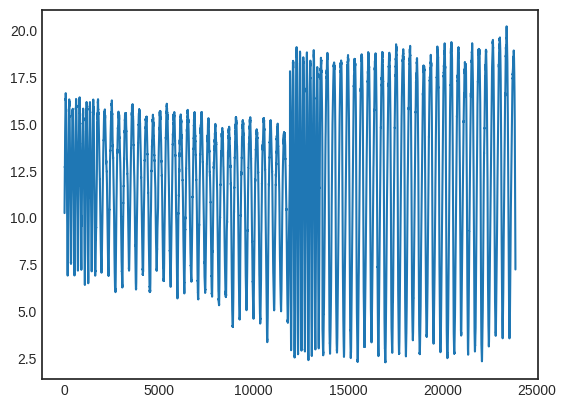

In [19]:
plt.plot(ice['Extent'])

In [20]:
ice.describe(include='all')

Year         Month           Day        Extent  Missing  \
count   23860.000000  23860.000000  23860.000000  23860.000000  23860.0   
unique           NaN           NaN           NaN           NaN      NaN   
top              NaN           NaN           NaN           NaN      NaN   
freq             NaN           NaN           NaN           NaN      NaN   
mean     1998.851635      6.550293     15.742917     11.603068      0.0   
std         9.951976      3.447684      8.802258      4.586068      0.0   
min      1978.000000      1.000000      1.000000      2.264000      0.0   
25%      1991.000000      4.000000      8.000000      7.747750      0.0   
50%      1999.000000      7.000000     16.000000     12.297000      0.0   
75%      2007.000000     10.000000     23.000000     15.197250      0.0   
max      2015.000000     12.000000     31.000000     20.201000      0.0   

                                              Source Data hemisphere  
count                                               23860      23860  
unique                                              23860          2  
top     ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
freq                                                    1      11930  
mean                                                  NaN        NaN  
std                                                   NaN        NaN  
min                                                   NaN        NaN  
25%                                                   NaN        NaN  
50%                                                   NaN        NaN  
75%                                                   NaN        NaN  
max                                                   NaN        NaN

Observando las variables regresoras vemos que `hemisphere` sólo toma dos valores, y nos limitamos a estudiar el casquete del polo norte.

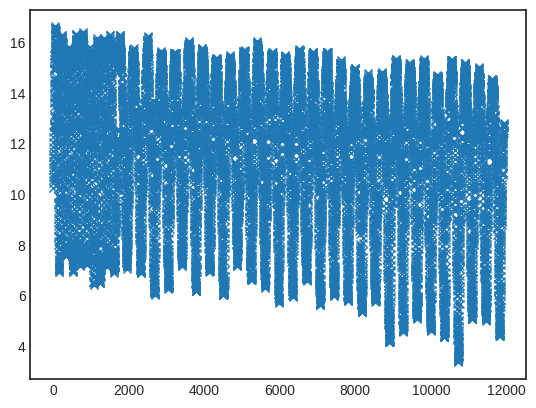

In [21]:
icen = ice[ice['hemisphere']=='north']
plt.plot(icen['Extent'],'x')

Observamos las primeras y las últimas entradas de `icen`:

In [22]:
icen.head()

Year  Month  Day  Extent  Missing  \
0  1978     10   26  10.231      0.0   
1  1978     10   28  10.420      0.0   
2  1978     10   30  10.557      0.0   
3  1978     11    1  10.670      0.0   
4  1978     11    3  10.777      0.0   

                                         Source Data hemisphere  
0  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
1  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
2  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
3  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
4  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north

In [23]:
icen.tail()

Year  Month  Day  Extent  Missing  \
11925  2015     12   27  12.680      0.0   
11926  2015     12   28  12.745      0.0   
11927  2015     12   29  12.762      0.0   
11928  2015     12   30  12.800      0.0   
11929  2015     12   31  12.735      0.0   

                                             Source Data hemisphere  
11925  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11926  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11927  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11928  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11929  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north

vemos que las entradas están ordenadas cronológicamente, una medición cada dos días al principio y una cada día al final.

Haciendo un poco de zoom vemos un patrón estacional muy fuerte, que no deja ver la tendencia a largo plazo

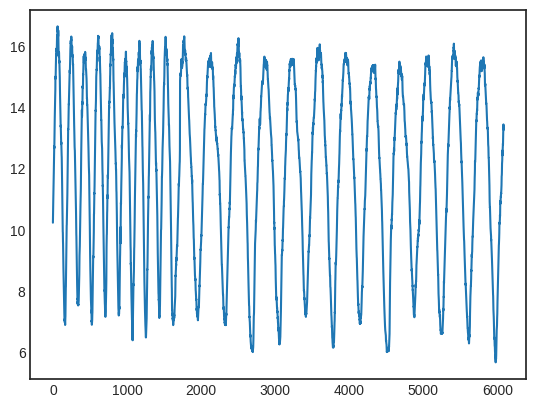

In [24]:
icen2000 = ice[(ice['hemisphere']=='north') & (ice['Year'] < 2000)]
plt.plot(icen2000['Extent'])

Si seleccionamos un único mes del año, entonces se aprecia la tendencia descendiente del hielo.

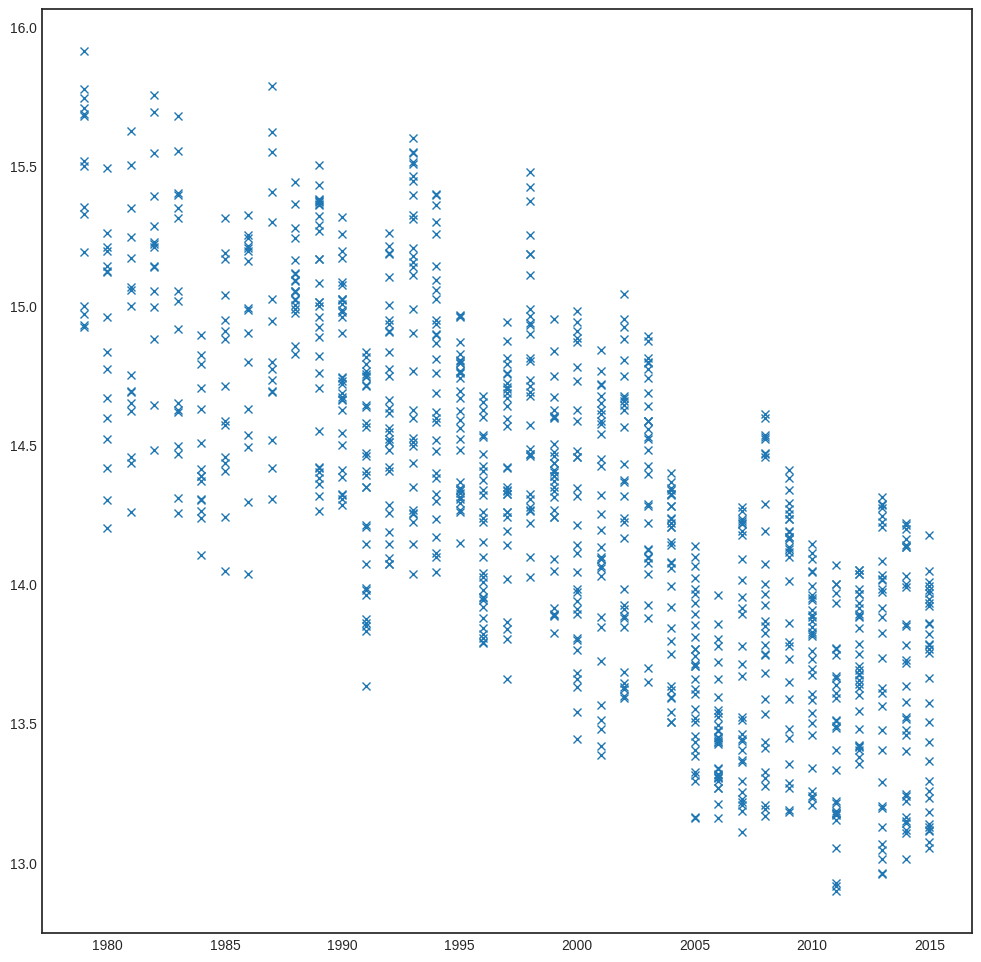

In [25]:
icenM = ice[(ice['hemisphere']=='north') & (ice['Month']==1)]
plt.figure(figsize=(12,12))
plt.plot(icenM['Year'], icenM['Extent'], 'x')

Otra forma distinta de capturar la tendencia es usar regresión. Pero un modelo `Extent ~ Year` da un resultado muy malo, porque la variación de un año a otro es pequeña comparada con la variación interanual.

In [26]:
est = smf.ols('Extent ~ Year', icen).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     329.7
Date:                Sun, 28 May 2023   Prob (F-statistic):           1.06e-72
Time:                        14:04:59   Log-Likelihood:                -30792.
No. Observations:               11930   AIC:                         6.159e+04
Df Residuals:                   11928   BIC:                         6.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    118.1817      5.879     20.102      0.000     106.658     129.706
Year          -0.0534      0.003    -18.158      0.000      -0.059      -0.048
==============================================================================
Omnibus:                     8026.070   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.123
Skew:                          -0.391   Prob(JB):                    2.43e-213
Kurtosis:                       1.835   Cond. No.                     4.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Es posible introducir una variable al cuadrado como variable regresora, e intentamos un modelo polinómico, de orden 2:

$$
    E = \beta_0 + \beta_{Y}\cdot Year + \beta_{Y,2}\cdot Year^2 + \varepsilon
$$

pero el modelo no es mejor:

In [27]:
est = smf.ols('Extent ~ Year + np.power(Year,2)', icen).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sun, 28 May 2023   Prob (F-statistic):           1.01e-72
Time:                        14:04:59   Log-Likelihood:                -30789.
No. Observations:               11930   AIC:                         6.158e+04
Df Residuals:                   11927   BIC:                         6.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2894.4776   1194.924     -2.422      0.015   -5236.723    -552.232
Year                  2.9623      1.196      2.477      0.013       0.618       5.307
np.power(Year, 2)    -0.0008      0.000     -2.521      0.012      -0.001      -0.000
==============================================================================
Omnibus:                     8311.875   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              980.350
Skew:                          -0.389   Prob(JB):                    1.32e-213
Kurtosis:                       1.830   Cond. No.                     1.63e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ejercicio 2

Para este ejercicio, usa únicamente los datos del hemisferio norte.

 - Elige un día de verano, selecciona sólo los datos de ese día para cada año estudiado, y ajusta un modelo de regresión lineal a la extensión del hielo para los datos de ese día.
 - Construye un modelo cuadrático con el año como variable explicativa, para el día de verano elegido. Compara los dos modelos.
 - Usa los dos modelos, lineal y cuadrático, para extrapolar la extensión del hielo en el Oceáno Ártico en Agosto de 2030, 2040 y 2050.
 - Compara tus predicciones con las obtenidas de ajustar un modelo `'Extent ~ Year + np.power(Year,2) + C(Month)'` para todos los registros del polo norte.

In [28]:
#  - Elige un día de verano, selecciona sólo los datos de ese día para cada año estudiado, 
#    y ajusta un modelo de regresión lineal a la extensión del hielo para los datos de ese día.
#15 de agosto
icen15A = ice[(ice['hemisphere']=='north') & (ice['Month']==8) & (ice['Day']==15)]
est = smf.ols('Extent ~ Year', icen15A).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     85.73
Date:                Sun, 28 May 2023   Prob (F-statistic):           2.66e-10
Time:                        14:04:59   Log-Likelihood:                -20.713
No. Observations:                  32   AIC:                             45.43
Df Residuals:                      30   BIC:                             48.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    168.9461     17.502      9.653      0.000     133.202     204.690
Year          -0.0811      0.009     -9.259      0.000      -0.099      -0.063
==============================================================================
Omnibus:                        2.594   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                1.481
Skew:                          -0.489   Prob(JB):                        0.477
Kurtosis:                       3.391   Cond. No.                     4.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
#  - Construye un modelo cuadrático con el año como variable explicativa, para el día de verano elegido. 
# Compara los dos modelos.
#15 de agosto
est2 = smf.ols('Extent ~ Year + np.power(Year,2)', icen15A).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     51.40
Date:                Sun, 28 May 2023   Prob (F-statistic):           2.93e-10
Time:                        14:04:59   Log-Likelihood:                -18.091
No. Observations:                  32   AIC:                             42.18
Df Residuals:                      29   BIC:                             46.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -7868.4610   3537.004     -2.225      0.034   -1.51e+04    -634.475
Year                  7.9620      3.539      2.249      0.032       0.723      15.201
np.power(Year, 2)    -0.0020      0.001     -2.272      0.031      -0.004      -0.000
==============================================================================
Omnibus:                        3.979   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                2.638
Skew:                          -0.665   Prob(JB):                        0.267
Kurtosis:                       3.456   Cond. No.                     1.79e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El modelo cuadrático tiene mejores indicadores adj-R2, AIC y BIC.

_Aviso_: El resultado puede depender del día elegido.

In [32]:
# - Usa los dos modelos, lineal y cuadrático, 
#   para extrapolar la extensión del hielo en el Oceáno Ártico en Agosto de 2030, 2040 y 2050.
# Para hacer predicciones con este modelo solo es necesario introducir el año, ya que el día y el mes
# son los mismos
futuro = pd.DataFrame({
    'Year': [2030, 2040, 2050]
})
print('## Modelo lineal')
print(est.predict(futuro))
print('## Modelo cuadrático')
print(est2.predict(futuro))

## Modelo lineal
0    4.401070
1    3.590504
2    2.779937
dtype: float64
## Modelo cuadrático
0    2.610776
1    0.337247
2   -2.338707
dtype: float64


Vemos que la predicción del modelo cuadrático es una superficie negativa, lo que obviamente es imposible. El resultado puede depender del día, pero cualquier modelo lineal, o cuadrático con curvatura negativa, eventualmente cruzará el eje de las x. Se puede interpretar que el modelo predice que en torno a 2041 ya no habrá hielo a mediados de agosto.

> - Compara tus predicciones con las obtenidas de ajustar un modelo 'Extent ~ Year + np.power(Year,2) + C(Month)' para todos los registros del polo norte.

In [31]:
icen = ice[ice.hemisphere=='north']
futuro = pd.DataFrame({
    'Year': [2030, 2040, 2050],
    'Month': [8, 8, 8]
})

regr_completo=smf.ols('Extent ~ Year + np.power(Year,2) + C(Month)', icen).fit()
regr_completo.predict(futuro)

0    4.521145
1    3.444049
2    2.226170
dtype: float64

Vemos unas predicciones similares a las del modelo lineal para el día 15 de agosto... el resultado ya sabemos que depende del día elegido.

No podemos comparar los indicadores AIC, BIC, de los modelos para el 15 de agosto con los de los modelos que usan todos los datos, ya que usan conjuntos de datos diferentes.